In [1]:
import os
import time
from io import StringIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

#preprocessing
from sklearn.model_selection import TimeSeriesSplit

from sklearn.impute import SimpleImputer
#model
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import lightgbm as lgb
from prophet import Prophet

#metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from google.cloud import storage

In [2]:
def read_data_from_gcs(bucket_name, folder, filename, delimiter=','):
    start_time = time.time()  # Start measuring time
    blob = storage_client.get_bucket(bucket_name).blob(f'{folder}/{filename}')
    csv_data = blob.download_as_text()
    df = pd.read_csv(StringIO(csv_data), delimiter=delimiter)
    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Read {filename} complete. Elapsed time: {elapsed_time:.2f} seconds")
    return df

def remove_lawyers(df, lawyer_ids):
    filtered_df = df[~df['lawyer_id'].isin(lawyer_ids)]
    return filtered_df

# Function to create lagged features for time series data
def create_lagged_features(data, lag):
    lagged_data = data.copy()
    for i in range(1, lag + 1):
        lagged_data[f'Lag_{i}'] = data['count'].shift(i)
    return lagged_data

def data_process_ml(df, train_index, test_index):
    
    df = df.set_index('date', inplace=False)

    lag = 7  # Number of lagged values, adjust as needed
    # Apply the function to create lagged features
    lagged_df = create_lagged_features(df, lag)
    
    X = lagged_df.drop(['count'], axis=1)
    y = lagged_df['count']
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    return X_train, y_train, X_test, y_test

def model_linear_regression(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred
    
def model_lgb(X_train, y_train, X_test):
    model = lgb.LGBMRegressor(verbose=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred
    
def model_xgboost(X_train, y_train, X_test):
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

def produce_metrics(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    return [mae, rmse, mape]

def visualize(df, x, y):
    # Set a Seaborn style and color palette
    sns.set_style("whitegrid")
    sns.set_palette("tab10")

    # Create a line plot
    plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
    sns.lineplot(data=df, x=x, y=y)

    # Customize the plot
    plt.title('Daily Chat Consultations', fontsize=16)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

    # Add grid lines
    plt.grid(True, alpha=0.5)

    # Show the plot
    plt.tight_layout()  # Ensure all elements fit nicely
    plt.show()
    
    
def metrics_results(model_score):
    num_rows = len(model_score)
    # Initialize a list to store the column sums
    column_sums = []

    # Calculate the sum of each column
    for col in range(len(model_score[0])):
        col_sum = sum(row[col] for row in model_score)
        column_sums.append(col_sum / num_rows)

    return column_sums

def data_process_stats(df, train_index, test_index):
    time_series = df['count']
    train_data, test_data = time_series[train_index], time_series[test_index]
    return train_data, test_data

def model_auto_arima(train_data, test_data):
    auto_model = auto_arima(train_data, seasonal=True, m=7, trace=True)
    n_forecast = len(test_data)
    y_pred, conf_int = auto_model.predict(n_forecast, return_conf_int=True)
    return y_pred

def data_process_prophet(df, train_index, test_index):
    df = df.rename(columns={'date': 'ds', 'count': 'y'}, inplace=False)
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
    return train_data, test_data

def model_prophet(train_data_pr, test_data_pr):
    model = Prophet()
    model.fit(train_data_pr)
    y_pred = model.predict(test_data_pr)
    return y_pred['yhat']

In [3]:
# Set path
relative_path = '../../deep-flash-sa.json'
file_path = os.path.abspath(relative_path)
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = file_path
storage_client = storage.Client()

In [4]:
df_consultations = read_data_from_gcs('perqara-dendrobium', 'raw/postgres/csv/consultations', 'consultations.csv', delimiter='|')
df_availability_instants = read_data_from_gcs('perqara-dendrobium', 'raw/postgres/csv/availability_instants', 'availability_instants.csv', delimiter=',')

Read consultations.csv complete. Elapsed time: 3.37 seconds
Read availability_instants.csv complete. Elapsed time: 2.13 seconds


In [5]:
#remove testing user
df_consultations = remove_lawyers(df_consultations, [36, 38, 48, 120, 192, 195])
df_consultations = df_consultations[df_consultations['status'] == 600]
df_consultations['created_at'] = pd.to_datetime(df_consultations['created_at'])

count = df_consultations['created_at'].to_frame().reset_index(drop=True)
# Set 'timestamp' as the DataFrame index
count.set_index('created_at', inplace=True)
# Resample the data to daily count and reset the index
df_daily_count = count.resample('D').size().reset_index()
# Rename the columns
df_daily_count.rename(columns={'created_at': 'date', 0: 'count'}, inplace=True)

In [6]:
# #remove testing user
# df_consultations = remove_lawyers(df_consultations, [36, 38, 48, 120, 192, 195])
# df_consultations = df_consultations[df_consultations['status'] == 600]
# df_consultations['created_at'] = pd.to_datetime(df_consultations['created_at'])

# count = df_consultations['created_at'].to_frame().reset_index(drop=True)
# # Set 'timestamp' as the DataFrame index
# count.set_index('created_at', inplace=True)

In [7]:
# df_daily_count = df_daily_count[df_daily_count['date'] < '2023-11-10']
df_daily_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    219 non-null    datetime64[ns]
 1   count   219 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.5 KB


In [8]:
df_daily_count[(df_daily_count['date'] < '2023-10-21') &  (df_daily_count['date'] > '2023-09-30')].sum()

/var/folders/fh/5kqpbzgx5cgdq_m9npj98tfh0000gn/T/ipykernel_88901/851050356.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_daily_count[(df_daily_count['date'] < '2023-10-21') &  (df_daily_count['date'] > '2023-09-30')].sum()


count    469
dtype: int64

In [8]:
df_daily_count[(df_daily_count['date'] < '2023-11-21') &  (df_daily_count['date'] > '2023-10-31')].sum()

/var/folders/fh/5kqpbzgx5cgdq_m9npj98tfh0000gn/T/ipykernel_2279/2084312522.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_daily_count[(df_daily_count['date'] < '2023-11-21') &  (df_daily_count['date'] > '2023-10-31')].sum()


count    548
dtype: int64

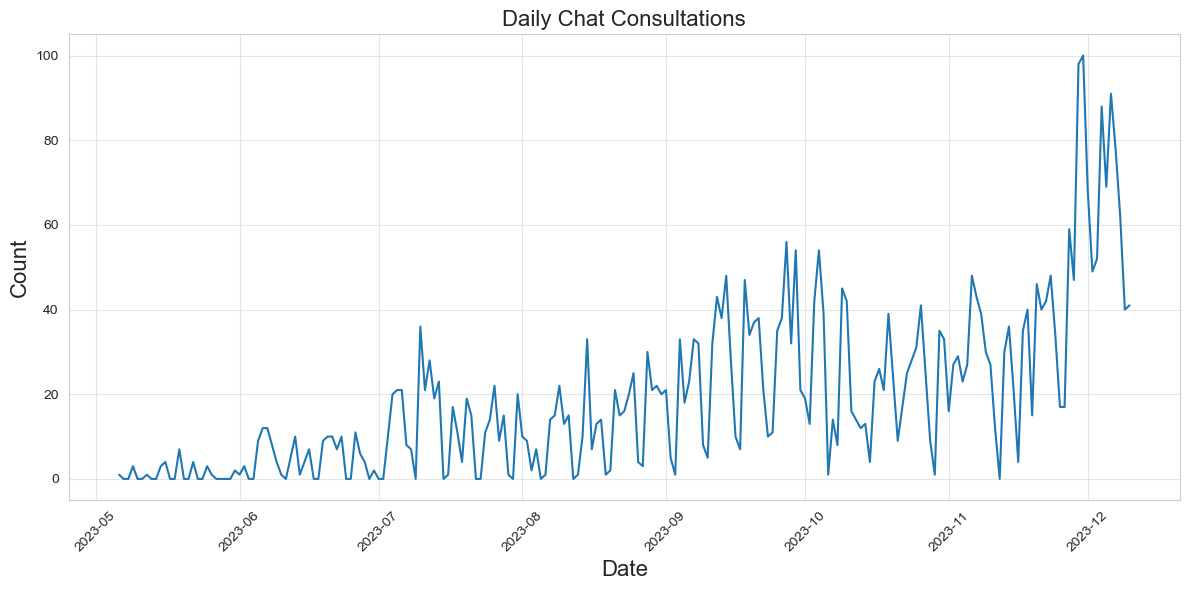

In [9]:
visualize(df_daily_count, 'date', 'count')

In [10]:
ml_data = create_lagged_features(df_daily_count, 7)
ml_data_fill = ml_data.fillna(ml_data.mean())
ml_data_fill

/var/folders/fh/5kqpbzgx5cgdq_m9npj98tfh0000gn/T/ipykernel_88901/2080527610.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ml_data_fill = ml_data.fillna(ml_data.mean())


,date,count,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7
0,2023-05-06,1,18.912844,18.815668,18.615741,18.339535,18.0,17.760563,17.429245
1,2023-05-07,0,1.000000,18.815668,18.615741,18.339535,18.0,17.760563,17.429245
2,2023-05-08,0,0.000000,1.000000,18.615741,18.339535,18.0,17.760563,17.429245
3,2023-05-09,3,0.000000,0.000000,1.000000,18.339535,18.0,17.760563,17.429245
4,2023-05-10,0,3.000000,0.000000,0.000000,1.000000,18.0,17.760563,17.429245
...,...,...,...,...,...,...,...,...,...
214,2023-12-06,91,69.000000,88.000000,52.000000,49.000000,68.0,100.000000,98.000000
215,2023-12-07,78,91.000000,69.000000,88.000000,52.000000,49.0,68.000000,100.000000
216,2023-12-08,62,78.000000,91.000000,69.000000,88.000000,52.0,49.000000,68.000000
217,2023-12-09,40,62.000000,78.000000,91.000000,69.000000,88.0,52.000000,49.000000


# Add exogenous variable


## Availlibity Instance

In [11]:
testing_user = [36, 38, 48, 120, 192, 195]
df_availability_instants_filtered = remove_lawyers(df_availability_instants, testing_user)

In [12]:
df_time_online = df_availability_instants_filtered[['lawyer_id', 'start_datetime', 'end_datetime', 'created_at']].copy()
df_time_online['start_datetime'] = pd.to_datetime(df_time_online['start_datetime'])
df_time_online['end_datetime'] = pd.to_datetime(df_time_online['end_datetime'])
df_time_online['created_at'] = pd.to_datetime(df_time_online['created_at'])
df_time_online['duration'] = (df_time_online['end_datetime'] - df_time_online['start_datetime']).astype('timedelta64[m]') / 60
df_time_online['date'] = df_time_online['created_at'].dt.date 
df_time_online['date'] = pd.to_datetime(df_time_online['date'])
df_time_online = df_time_online[df_time_online['date'] < '2023-11-10']

#### Lawyer online duration

In [13]:
# #lawyer online
# daily_lawyer_online = df_time_online.groupby('date')['duration'].sum().reset_index()
# daily_lawyer_online = daily_lawyer_online.loc[2:]
# daily_lawyer_online = daily_lawyer_online[:-4]
# daily_lawyer_online = daily_lawyer_online.set_index('date')
# #fill missing data with 0 
# date_range = pd.date_range(start=daily_lawyer_online.index.min(), end=daily_lawyer_online.index.max(), freq='D')
# daily_lawyer_online = daily_lawyer_online.reindex(date_range, fill_value=0)
# daily_lawyer_online.head()

#### Lawyer count

In [14]:
#lawyer online 
working_hours_mask = (df_time_online['start_datetime'].dt.hour >= 10) & (df_time_online['end_datetime'].dt.hour <= 18)
late_hours_mask = (df_time_online['end_datetime'].dt.hour > 18) & (df_time_online['end_datetime'].dt.hour <= 24)

# Get the unique number of lawyers online during working hours and late hours for each day
working_hours_lawyers = df_time_online[working_hours_mask].groupby(df_time_online['date'])['lawyer_id'].nunique()
late_hours_lawyers = df_time_online[late_hours_mask].groupby(df_time_online['date'])['lawyer_id'].nunique()
daily_count = pd.DataFrame({'working_hours_lawyers': working_hours_lawyers, 'late_hours_lawyers': late_hours_lawyers})
daily_count = daily_count[1:]

date_range = pd.date_range(start=daily_count.index.min(), end=daily_count.index.max(), freq='D')
daily_count = daily_count.reindex(date_range, fill_value=0)

daily_count = daily_count.fillna(0)

In [931]:
# lawyer_online_daily = df_time_online.groupby('date')['lawyer_id'].nunique().reset_index()
# lawyer_online_daily = lawyer_online_daily.rename(columns={'lawyer_id':'lawyer_online_count'})
# lawyer_online_daily = lawyer_online_daily.loc[2:]
# lawyer_online_daily = lawyer_online_daily.set_index('date')

# #fill missing data with 0 
# date_range = pd.date_range(start=lawyer_online_daily.index.min(), end=lawyer_online_daily.index.max(), freq='D')
# lawyer_online_daily = lawyer_online_daily.reindex(date_range, fill_value=0)
# lawyer_online_daily.head()

<Axes: >

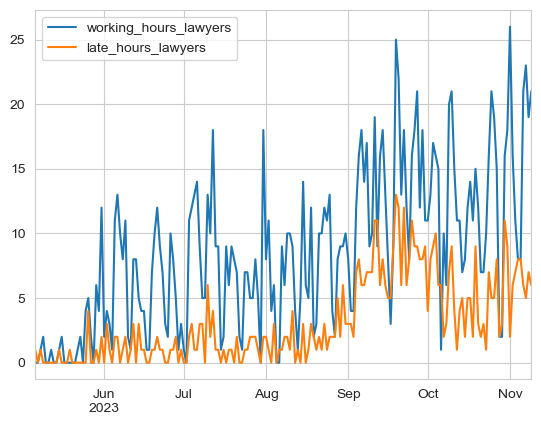

In [16]:
daily_count.plot()

#### Website Visitor

In [26]:
web_visitor = pd.read_csv('website-visitor_20231114.csv')
web_visitor = web_visitor.rename(columns={'event_date':'date', 'f0_':'web_visitor'})
web_visitor['date'] = pd.to_datetime(web_visitor['date'], format='%Y%m%d')

In [933]:
date_range = pd.date_range(start='2023-05-06', end='2023-06-25')
mean_count = web_visitor['web_visitor'].mean()
new_data = {'date': date_range, 'web_visitor': mean_count}
new_rows = pd.DataFrame(new_data)
df_visitor = pd.concat([web_visitor, new_rows]).sort_values('date')
# df_visitor = df_visitor[:-4]

In [934]:
df_ml_with_visitor = pd.merge(ml_data_fill, df_visitor, on='date')
df_ml_with_visitor.head()

,date,count,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,web_visitor
0,2023-05-06,1,14.572193,14.44086,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482
1,2023-05-07,0,1.000000,14.44086,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482
2,2023-05-08,0,0.000000,1.00000,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482
3,2023-05-09,3,0.000000,0.00000,1.000000,14.103261,14.032787,13.983516,13.900552,533.652482
4,2023-05-10,0,3.000000,0.00000,0.000000,1.000000,14.032787,13.983516,13.900552,533.652482


### Onboard Lawyer

In [935]:
# # Create a DataFrame with week numbers
# df = pd.DataFrame({'week': range(18, 43)})

# # Assuming you want the start date of each week (Monday)
# df['Start Date'] = pd.date_range(start='2023-05-01', periods=len(df), freq='W-MON')

# # Create a list to store daily dates
# daily_dates = []

# # Iterate through each week and create a daily date range
# for start_date in df['Start Date']:
#     daily_range = pd.date_range(start=start_date, periods=7)
#     daily_dates.extend(daily_range)

# # Create a new DataFrame with daily dates
# df_daily = pd.DataFrame({'week': df['week'].repeat(7), 'date': daily_dates})

# # Reset the index
# df_daily.reset_index(drop=True, inplace=True)

# # Display the resulting DataFrame
# df_daily.head()

# df_onboard = pd.read_csv('onboarding_lawyers.csv')
# df_onboard['week'] = df_onboard['week'].str.replace('W', '')
# df_onboard['week'] = df_onboard['week'].astype(int)

# merged_onboard = pd.merge(df_daily, df_onboard, on='week', how='left')
# merged_onboard = merged_onboard.drop(columns='target')
# merged_onboard['onboarded_shift_1_week'] = merged_onboard['onboarded_lawyers'].shift(7)
# merged_onboard['onboarded_shift_1_week'] = merged_onboard['onboarded_shift_1_week'].fillna(merged_onboard['onboarded_shift_1_week'].mean())
# merged_onboard = merged_onboard[['date', 'onboarded_shift_1_week']]

# merged_final = pd.merge(df_ml_with_visitor, merged_onboard, on='date', how='left')
# merged_final.set_index('date', inplace=True)
# merged_final

In [936]:
df_ml_with_visitor.set_index('date', inplace=True)

In [937]:
#add daily lawyer online and duration

merged_final_final = pd.merge(df_ml_with_visitor, daily_count, left_index=True, right_index=True)
# merged_final_final = pd.merge(merged_final_final, daily_lawyer_online, left_index=True, right_index=True)

In [938]:
merged_final_final

,count,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,web_visitor,working_hours_lawyers,late_hours_lawyers
date,,,,,,,,,,,
2023-05-06,1,14.572193,14.44086,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482,0.0,1.0
2023-05-07,0,1.000000,14.44086,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482,0.0,0.0
2023-05-08,0,0.000000,1.00000,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482,1.0,1.0
2023-05-09,3,0.000000,0.00000,1.000000,14.103261,14.032787,13.983516,13.900552,533.652482,2.0,0.0
2023-05-10,0,3.000000,0.00000,0.000000,1.000000,14.032787,13.983516,13.900552,533.652482,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-05,27,23.000000,29.00000,27.000000,16.000000,32.000000,33.000000,1.000000,286.000000,8.0,8.0
2023-11-06,48,27.000000,23.00000,29.000000,27.000000,16.000000,32.000000,33.000000,576.000000,21.0,6.0
2023-11-07,43,48.000000,27.00000,23.000000,29.000000,27.000000,16.000000,32.000000,598.000000,23.0,5.0


In [939]:
# merged_final_final['web_visitor_lag_1'] = merged_final_final['web_visitor'].shift(1)
# merged_final_final['web_visitor_lag_2'] = merged_final_final['web_visitor'].shift(2)
# merged_final_final = merged_final_final.fillna(merged_final_final.mean())

# for i in range(7):
#     merged_final_final[f'web_visitor_lag_{i+1}'] = merged_final_final['web_visitor'].shift(i+1)
#     merged_final_final[f'web_visitor_lag_{i+1}'] = merged_final_final[f'web_visitor_lag_{i+1}'].fillna(merged_final_final[f'web_visitor_lag_{i+1}'].mean())


In [940]:
#add CPA variable 
# google ads
df_google_ads = pd.read_csv('20231114-ads-google.csv')
# df_google_ads = df_google_ads[:-1]
df_google_ads = df_google_ads[['date','cost']]
df_google_ads['cost'] = df_google_ads['cost'].astype(int)
df_google_ads['date'] = pd.to_datetime(df_google_ads['date'])
df_google_ads.rename(columns={'cost': 'cost_google'}, inplace=True)
df_google_ads.set_index('date', inplace=True)

# meta ads
df_meta_ads = pd.read_csv('20231114-ads-meta.csv')
# df_meta_ads = df_meta_ads[:-1]
df_meta_ads = df_meta_ads[['date','cost']]
df_meta_ads['cost'] = df_meta_ads['cost'].astype(int)
df_meta_ads['date'] = pd.to_datetime(df_meta_ads['date'])
df_meta_ads.rename(columns={'cost': 'cost_meta'}, inplace=True)
df_meta_ads.set_index('date', inplace=True)

ads_cost = pd.merge(df_google_ads, df_meta_ads, left_index=True, right_index=True)

In [941]:
date_range = pd.date_range(start='2023-05-06', end='2023-06-30')
mean_cost_google = ads_cost['cost_google'].mean()
mean_cost_meta = ads_cost['cost_meta'].mean()
new_data = {'date': date_range, 'cost_google': mean_cost_google, 'cost_meta':mean_cost_meta}
new_rows = pd.DataFrame(new_data)
new_rows.set_index('date', inplace=True)
df_cost = pd.concat([ads_cost, new_rows]).sort_values('date')

In [942]:
df_visitor

,date,web_visitor
0,2023-05-06,533.652482
1,2023-05-07,533.652482
2,2023-05-08,533.652482
3,2023-05-09,533.652482
4,2023-05-10,533.652482
...,...,...
132,2023-11-05,286.000000
133,2023-11-06,576.000000
134,2023-11-07,598.000000
135,2023-11-08,525.000000


In [943]:
df_cost['cpa_google'] = df_cost['cost_google'].values / df_visitor['web_visitor'].values
df_cost['cpa_meta'] = df_cost['cost_meta'].values / df_visitor['web_visitor'].values

In [944]:
merged_final_final

,count,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,web_visitor,working_hours_lawyers,late_hours_lawyers
date,,,,,,,,,,,
2023-05-06,1,14.572193,14.44086,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482,0.0,1.0
2023-05-07,0,1.000000,14.44086,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482,0.0,0.0
2023-05-08,0,0.000000,1.00000,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482,1.0,1.0
2023-05-09,3,0.000000,0.00000,1.000000,14.103261,14.032787,13.983516,13.900552,533.652482,2.0,0.0
2023-05-10,0,3.000000,0.00000,0.000000,1.000000,14.032787,13.983516,13.900552,533.652482,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2023-11-05,27,23.000000,29.00000,27.000000,16.000000,32.000000,33.000000,1.000000,286.000000,8.0,8.0
2023-11-06,48,27.000000,23.00000,29.000000,27.000000,16.000000,32.000000,33.000000,576.000000,21.0,6.0
2023-11-07,43,48.000000,27.00000,23.000000,29.000000,27.000000,16.000000,32.000000,598.000000,23.0,5.0


In [945]:
merged_final_3 = pd.merge(merged_final_final, df_cost[['cpa_google', 'cpa_meta']], left_index=True, right_index=True)

In [946]:
bug = pd.read_csv('bug.csv')
bug = bug.rename(columns={'Unnamed: 0':'date'})
bug['date'] = pd.to_datetime(bug['date'])
bug.set_index('date', inplace=True)
start_date = '2023-05-06'
bug = bug.loc[start_date:]

In [947]:
inq = pd.read_csv('inq.csv')
inq = inq.rename(columns={'Unnamed: 0':'date', 'cum':'inq'})
inq['date'] = pd.to_datetime(inq['date'])
inq.set_index('date', inplace=True)
start_date = '2023-05-06'
inq = inq.loc[start_date:]

In [948]:
bug_inq = pd.merge(bug, inq, left_index=True, right_index=True)

<Axes: xlabel='date'>

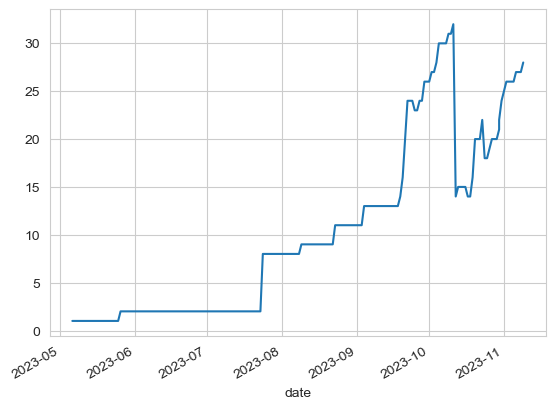

In [995]:
bug_inq['cum_major_bug'].plot()

In [949]:
bug_inq.rename(columns={'cumulative_major':'cum_major_bug', 'cumulative_minor':'cum_minor_bug'}, inplace=True)

In [950]:
merged_final_4 = pd.merge(merged_final_3, bug_inq, left_index=True, right_index=True)

In [951]:
merged_final_4

,count,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,web_visitor,working_hours_lawyers,late_hours_lawyers,cpa_google,cpa_meta,cum_major_bug,cum_minor_bug,inq
date,,,,,,,,,,,,,,,,
2023-05-06,1,14.572193,14.44086,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482,0.0,1.0,580.416838,421.559782,1.0,1.0,9.0
2023-05-07,0,1.000000,14.44086,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482,0.0,0.0,580.416838,421.559782,1.0,1.0,11.0
2023-05-08,0,0.000000,1.00000,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482,1.0,1.0,580.416838,421.559782,1.0,1.0,11.0
2023-05-09,3,0.000000,0.00000,1.000000,14.103261,14.032787,13.983516,13.900552,533.652482,2.0,0.0,580.416838,421.559782,1.0,3.0,9.0
2023-05-10,0,3.000000,0.00000,0.000000,1.000000,14.032787,13.983516,13.900552,533.652482,0.0,0.0,580.416838,421.559782,1.0,3.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-05,27,23.000000,29.00000,27.000000,16.000000,32.000000,33.000000,1.000000,286.000000,8.0,8.0,1252.769231,0.000000,26.0,11.0,185.0
2023-11-06,48,27.000000,23.00000,29.000000,27.000000,16.000000,32.000000,33.000000,576.000000,21.0,6.0,1632.736111,0.000000,27.0,12.0,184.0
2023-11-07,43,48.000000,27.00000,23.000000,29.000000,27.000000,16.000000,32.000000,598.000000,23.0,5.0,1607.311037,0.000000,27.0,12.0,185.0


In [952]:
df_ml_vis = merged_final_4.copy()
# df_ml_vis = df_ml_vis.drop(columns=['cum_major_bug', 'cum_minor_bug'])

In [970]:
df_ml_vis.to_csv('df_final_with_bug.csv')

In [971]:
df_ml_vis

,count,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,web_visitor,working_hours_lawyers,late_hours_lawyers,cpa_google,cpa_meta,cum_major_bug,cum_minor_bug,inq
date,,,,,,,,,,,,,,,,
2023-05-06,1,14.572193,14.44086,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482,0.0,1.0,580.416838,421.559782,1.0,1.0,9.0
2023-05-07,0,1.000000,14.44086,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482,0.0,0.0,580.416838,421.559782,1.0,1.0,11.0
2023-05-08,0,0.000000,1.00000,14.286486,14.103261,14.032787,13.983516,13.900552,533.652482,1.0,1.0,580.416838,421.559782,1.0,1.0,11.0
2023-05-09,3,0.000000,0.00000,1.000000,14.103261,14.032787,13.983516,13.900552,533.652482,2.0,0.0,580.416838,421.559782,1.0,3.0,9.0
2023-05-10,0,3.000000,0.00000,0.000000,1.000000,14.032787,13.983516,13.900552,533.652482,0.0,0.0,580.416838,421.559782,1.0,3.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-05,27,23.000000,29.00000,27.000000,16.000000,32.000000,33.000000,1.000000,286.000000,8.0,8.0,1252.769231,0.000000,26.0,11.0,185.0
2023-11-06,48,27.000000,23.00000,29.000000,27.000000,16.000000,32.000000,33.000000,576.000000,21.0,6.0,1632.736111,0.000000,27.0,12.0,184.0
2023-11-07,43,48.000000,27.00000,23.000000,29.000000,27.000000,16.000000,32.000000,598.000000,23.0,5.0,1607.311037,0.000000,27.0,12.0,185.0


In [954]:
# df_ml_vis = df_ml_vis.drop(columns='web_visitor')

In [955]:
exogenous_features = list(df_ml_vis.iloc[:, 1:].columns)

n_splits = 5  # You can adjust the number of splits as needed
tscv = TimeSeriesSplit(n_splits=n_splits)

scores_prophet = []

df = df_ml_vis.copy()
df.reset_index(inplace=True)

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    print(f"Fold {i}:")
    print(train_index)
    print(test_index)
    
    train_data_pr, test_data_pr = df.iloc[train_index], df.iloc[test_index]
    model = Prophet()
    for feature in exogenous_features:
        model.add_regressor(feature)
    
    model.fit(train_data_pr[["date", "count"] + exogenous_features].rename(columns={"date": "ds", "count": "y"}))
    y_pred = model.predict(test_data_pr[["date", "count"] + exogenous_features].rename(columns={"date": "ds", "count": "y"}))
    y_pred_new = y_pred['yhat']
        
    metrics_prophet = produce_metrics(test_data_pr['count'], y_pred_new)
    
    scores_prophet.append(metrics_prophet)
    
    print(f"Fold metrics prophet: {scores_prophet}")
    
print("Metrics prophet:", scores_prophet)

11:20:42 - cmdstanpy - INFO - Chain [1] start processing


Fold 0:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65]


11:20:43 - cmdstanpy - INFO - Chain [1] done processing
11:20:43 - cmdstanpy - INFO - Chain [1] start processing
11:20:43 - cmdstanpy - INFO - Chain [1] done processing


Fold metrics prophet: [[4.840097583790867, 7.990344902655145, 2525324101496747.0]]
Fold 1:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65]
[66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89
 90 91 92 93 94 95 96]


11:20:43 - cmdstanpy - INFO - Chain [1] start processing
11:20:43 - cmdstanpy - INFO - Chain [1] done processing


Fold metrics prophet: [[4.840097583790867, 7.990344902655145, 2525324101496747.0], [14.074646201059087, 15.89689612785827, 6182095847351188.0]]
Fold 2:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96]
[ 97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127]
Fold metrics prophet: [[4.840097583790867, 7.990344902655145, 2525324101496747.0], [14.074646201059087, 15.89689612785827, 6182095847351188.0], [6.0174814333091255, 7.382794017721335, 458976442670849.3]]
Fold 3:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  

11:20:43 - cmdstanpy - INFO - Chain [1] start processing
11:20:43 - cmdstanpy - INFO - Chain [1] done processing
11:20:43 - cmdstanpy - INFO - Chain [1] start processing
11:20:43 - cmdstanpy - INFO - Chain [1] done processing


Fold metrics prophet: [[4.840097583790867, 7.990344902655145, 2525324101496747.0], [14.074646201059087, 15.89689612785827, 6182095847351188.0], [6.0174814333091255, 7.382794017721335, 458976442670849.3], [10.836517703943747, 13.393792032971321, 0.6691503566201598]]
Fold 4:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158]
[159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 17

In [956]:
# df_prophet = df.copy()
# df_prophet.sort_values(by='date', inplace=True)
# df_prophet.rename(columns={'date': 'ds', 'count': 'y'}, inplace=True)

# future_dates = model.make_future_dataframe(periods=77)

# forecast = model.predict(future_dates)
# forecast_result = forecast[forecast['ds'] >= '2023-10-04'][['ds','yhat', 'yhat_lower', 'yhat_upper']]
# forecast_result

In [986]:
df_ml_vis[-20:]

,count,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,web_visitor,working_hours_lawyers,late_hours_lawyers,cpa_google,cpa_meta,cum_major_bug,cum_minor_bug,inq
date,,,,,,,,,,,,,,,,
2023-10-22,17,9.0,24.0,39.0,21.0,26.0,23.0,4.0,381.0,3.0,2.0,914.288714,282.955381,20.0,9.0,176.0
2023-10-23,25,17.0,9.0,24.0,39.0,21.0,26.0,23.0,642.0,10.0,1.0,856.442368,123.638629,22.0,9.0,166.0
2023-10-24,28,25.0,17.0,9.0,24.0,39.0,21.0,26.0,512.0,16.0,7.0,959.515625,99.617188,18.0,9.0,165.0
2023-10-25,31,28.0,25.0,17.0,9.0,24.0,39.0,21.0,564.0,21.0,5.0,825.028369,86.726950,18.0,9.0,166.0
2023-10-26,41,31.0,28.0,25.0,17.0,9.0,24.0,39.0,730.0,19.0,5.0,614.950685,29.034247,19.0,9.0,167.0
2023-10-27,25,41.0,31.0,28.0,25.0,17.0,9.0,24.0,498.0,12.0,6.0,776.463855,58.403614,20.0,9.0,164.0
2023-10-28,9,25.0,41.0,31.0,28.0,25.0,17.0,9.0,320.0,1.0,2.0,766.131250,145.012500,20.0,9.0,169.0
2023-10-29,1,9.0,25.0,41.0,31.0,28.0,25.0,17.0,224.0,2.0,3.0,909.593750,236.308036,20.0,9.0,170.0
2023-10-30,33,1.0,9.0,25.0,41.0,31.0,28.0,25.0,491.0,16.0,11.0,965.456212,103.391039,21.0,10.0,169.0


In [957]:
time_series = df_ml_vis['count']

df = df_ml_vis.copy()

scores_arimax = []

n_splits = 5  # You can adjust the number of splits as needed
tscv = TimeSeriesSplit(n_splits=n_splits)

for i, (train_index, test_index) in enumerate(tscv.split(df)):
    print(f"Fold {i}:")
    print(train_index)
    print(test_index)
    
    time_series = df['count']
    train_data, test_data = time_series[train_index], time_series[test_index]
    
#     model = auto_arima(train_data, exogenous=df_ml_vis.iloc[:, 1:].iloc[train_index], seasonal=True, m=7, trace=True)
    model = auto_arima(train_data, seasonal=True, m=7, trace=True)
    n_forecast = len(test_data)
    y_pred, conf_int = model.predict(n_forecast, return_conf_int=True)
    
    metrics_arimax = produce_metrics(test_data, y_pred)
    
    scores_arimax.append(metrics_arimax)
    
    print(f"Fold metrics arimax: {metrics_arimax}")
    
print("Metrics arimax:", scores_arimax)

Fold 0:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
[35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65]
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=182.432, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=188.605, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=178.304, Time=0.02 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=176.041, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=199.231, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=174.131, Time=0.01 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=176.023, Time=0.02 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=177.964, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=175.857, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[7] intercept   : AIC=175.941, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=176.413, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[7] interc

 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=936.771, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=875.447, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=934.772, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=927.479, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=856.344, Time=0.10 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=849.776, Time=0.18 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=848.315, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=903.174, Time=0.07 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=849.802, Time=0.18 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=884.558, Time=0.11 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=851.649, Time=0.17 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=883.596, Time=0.05 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=845.154, Time=0.36 sec
 ARIMA(2,1,0)(0,0,1)[7] intercept

 ARIMA(4,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(5,1,2)(2,0,1)[7] intercept   : AIC=1108.192, Time=0.79 sec
 ARIMA(4,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(5,1,1)(2,0,1)[7]             : AIC=1103.718, Time=0.84 sec
 ARIMA(5,1,1)(1,0,1)[7]             : AIC=1102.354, Time=0.52 sec
 ARIMA(5,1,1)(0,0,1)[7]             : AIC=1132.417, Time=0.22 sec
 ARIMA(5,1,1)(1,0,0)[7]             : AIC=1122.779, Time=0.27 sec
 ARIMA(5,1,1)(1,0,2)[7]             : AIC=1103.878, Time=0.75 sec
 ARIMA(5,1,1)(0,0,0)[7]             : AIC=1137.354, Time=0.09 sec
 ARIMA(5,1,1)(0,0,2)[7]             : AIC=1126.398, Time=0.53 sec
 ARIMA(5,1,1)(2,0,0)[7]             : AIC=1105.581, Time=0.69 sec
 ARIMA(5,1,1)(2,0,2)[7]             : AIC=1105.456, Time=2.39 sec
 ARIMA(4,1,1)(1,0,1)[7]             : AIC=1100.476, Time=0.49 sec
 ARIMA(4,1,1)(0,0,1)[7]             : AIC=1142.823, Time=0.38 sec
 ARIMA(4,1,1)(1,0,0)[7]             : AIC=1112.795, Time=0.31 sec
 ARIMA(4,1,1)(2,0,1)

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [961]:
scores_lr = []
scores_lgb = []
scores_xgb = []

n_splits = 5  # You can adjust the number of splits as needed
tscv = TimeSeriesSplit(n_splits=n_splits)
for i, (train_index, test_index) in enumerate(tscv.split(df_ml_vis)):

    X = df_ml_vis.drop(['count'], axis=1)
    y = df_ml_vis['count']

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    y_pred_lr = model_linear_regression(X_train, y_train, X_test)
    y_pred_lgb = model_lgb(X_train, y_train, X_test)
    y_pred_xgb = model_xgboost(X_train, y_train, X_test)
    
    metrics_lr = produce_metrics(y_test, y_pred_lr)
    metrics_lgb = produce_metrics(y_test, y_pred_lgb)
    metrics_xgb = produce_metrics(y_test, y_pred_xgb)
    
    scores_lr.append(metrics_lr)
    scores_lgb.append(metrics_lgb)
    scores_xgb.append(metrics_xgb)
    
    print(f"Fold RMSE lr: {metrics_lr}")
    print(f"Fold RMSE lgb: {metrics_lgb}")
    print(f"Fold RMSE xgb: {metrics_xgb}")
    
print("Metrics lr:", scores_lr)
print("Metrics lgb:", scores_lgb)
print("Metrics xgb:", scores_xgb)

Fold RMSE lr: [18568136547.28396, 33501644006.33128, 4.1140929336998325e+25]
Fold RMSE lgb: [6.335483870967742, 9.441485360875065, 2913849712824044.5]
Fold RMSE xgb: [4.274640931237128, 6.732886378574662, 2627045270030402.0]
Fold RMSE lr: [18.263504441012856, 21.46797756311108, 8511234279247128.0]
Fold RMSE lgb: [4.88552242992599, 6.3003676181404495, 2077190752464337.0]
Fold RMSE xgb: [7.6152266844986904, 9.402136543884314, 1793943624744961.0]
Fold RMSE lr: [5.475761519355103, 6.875086047823616, 628698582330612.5]
Fold RMSE lgb: [5.036702690066314, 6.791592228039279, 67042953544379.55]
Fold RMSE xgb: [5.799198577480931, 7.88175284044158, 279972413575300.8]
Fold RMSE lr: [10.85378381345879, 13.537830603172875, 0.6038805859078371]
Fold RMSE lgb: [10.133073305899236, 12.810611757558812, 0.8124369712375727]
Fold RMSE xgb: [11.600468520195253, 14.156996183582446, 0.7607355153190138]
Fold RMSE lr: [7.005657090954589, 9.360089857187747, 0.877177626554304]
Fold RMSE lgb: [6.151120251067103, 7.

In [962]:
avg_lr = metrics_results(scores_lr)
avg_lgb = metrics_results(scores_lgb)
avg_xgb = metrics_results(scores_xgb)
avg_arimax = metrics_results(scores_arimax)
avg_prophet = metrics_results(scores_prophet)

# Create a Pandas DataFrame
df_model = pd.DataFrame({'Model': ['Linear Regression', 'LightGBM', 'XGBoost', 'Arimax', 'Prophet']})
df_res = pd.DataFrame([avg_lr, avg_lgb, avg_xgb, avg_arimax, avg_prophet])
df_res.columns = ['MAE', 'RMSE', 'MAPE']
df_final_scores = pd.concat([df_model, df_res], axis=1)
df_final_scores

,Model,MAE,RMSE,MAPE
0,Linear Regression,3.713627e+09,6.700329e+09,8.228186e+24
1,LightGBM,6.508381e+00,8.607984e+00,1.011617e+15
2,XGBoost,7.067129e+00,9.097067e+00,9.401923e+14
3,Arimax,8.988117e+00,1.125385e+01,1.827267e+15
4,Prophet,8.992137e+00,1.117289e+01,1.833279e+15


In [963]:
# Highlight the highest value in each numeric column
def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

# Select only the numeric columns for highlighting
numeric_cols = ['MAE', 'RMSE', 'MAPE']
highlighted_metrics_df = df_final_scores.style.apply(highlight_min, subset=numeric_cols, axis=0)

# Display the highlighted DataFrame
highlighted_metrics_df

,Model,MAE,RMSE,MAPE
0,Linear Regression,3713627317.776533,6700328811.514453,8228185869227651057582080.000000
1,LightGBM,6.508381,8.607984,1011616683766552.750000
2,XGBoost,7.067129,9.097067,940192261670133.250000
3,Arimax,8.988117,11.253852,1827267475427910.000000
4,Prophet,8.992137,11.172892,1833279278303757.250000


In [964]:
model_lr.coef_

array([ 0.09692369,  0.01810335, -0.04572882,  0.0988811 , -0.03387679,
        0.18439046,  0.08485814,  0.01072721,  1.01811078,  0.41590274,
        0.00670821,  0.00136929,  0.02409603])

Text(0, 0.5, 'Importance')

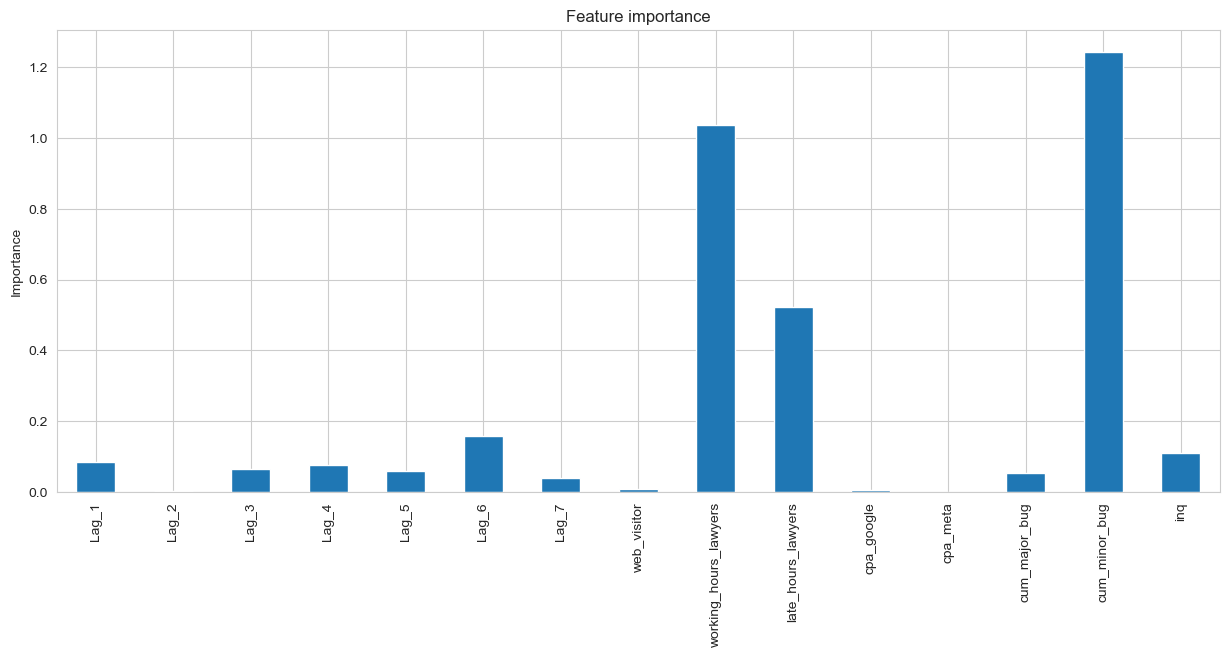

In [965]:
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

tmp = pd.Series(np.abs(model_lr.coef_))
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")

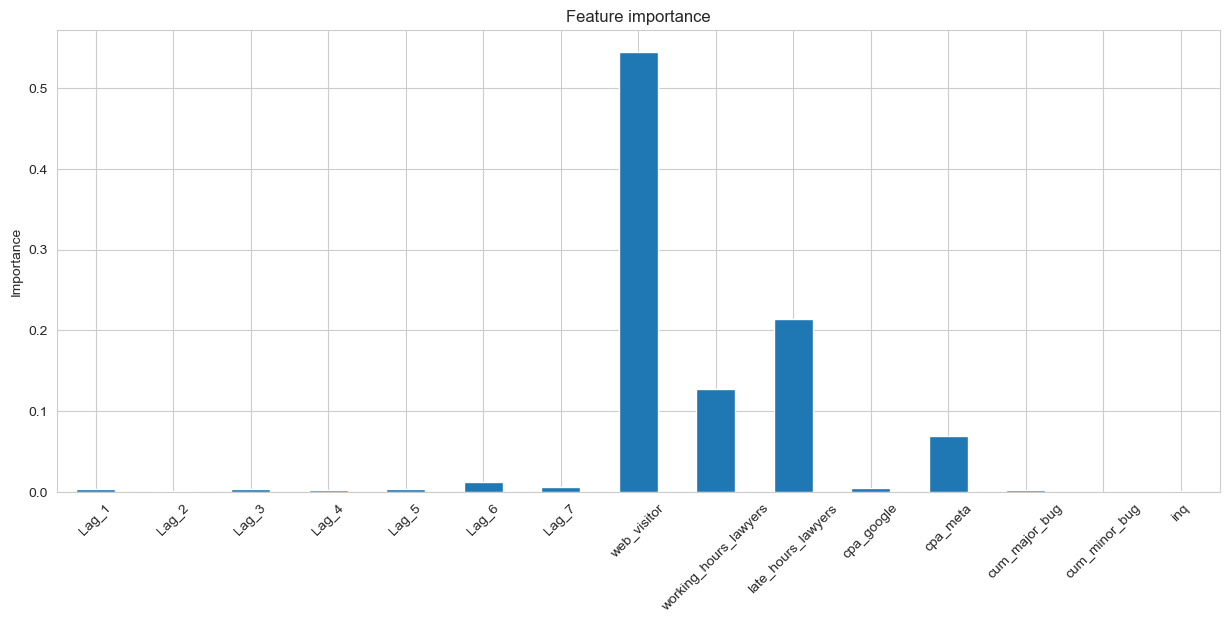

In [966]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
tmp = pd.Series(model.feature_importances_)
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")

# Rotate the y-axis labels by 45 degrees
plt.xticks(rotation=45)
plt.show()

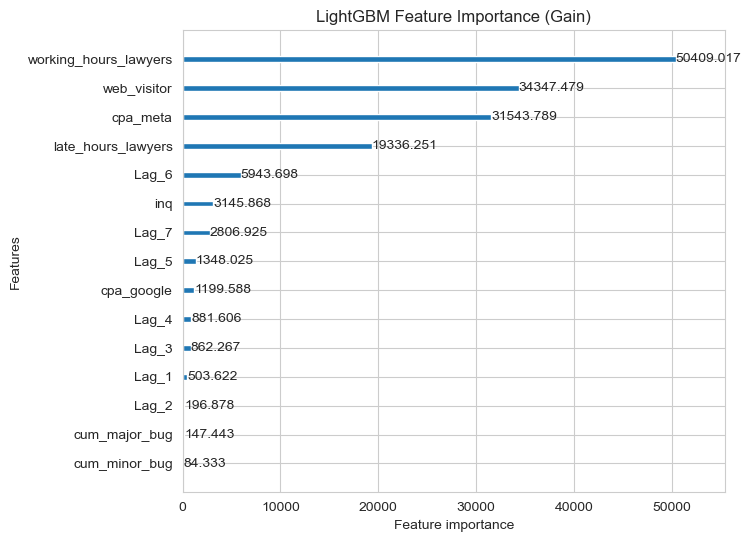

In [967]:
model = lgb.LGBMRegressor(verbose=-1)
model.fit(X_train, y_train)
# Plot feature importance using Gain
lgb.plot_importance(model, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

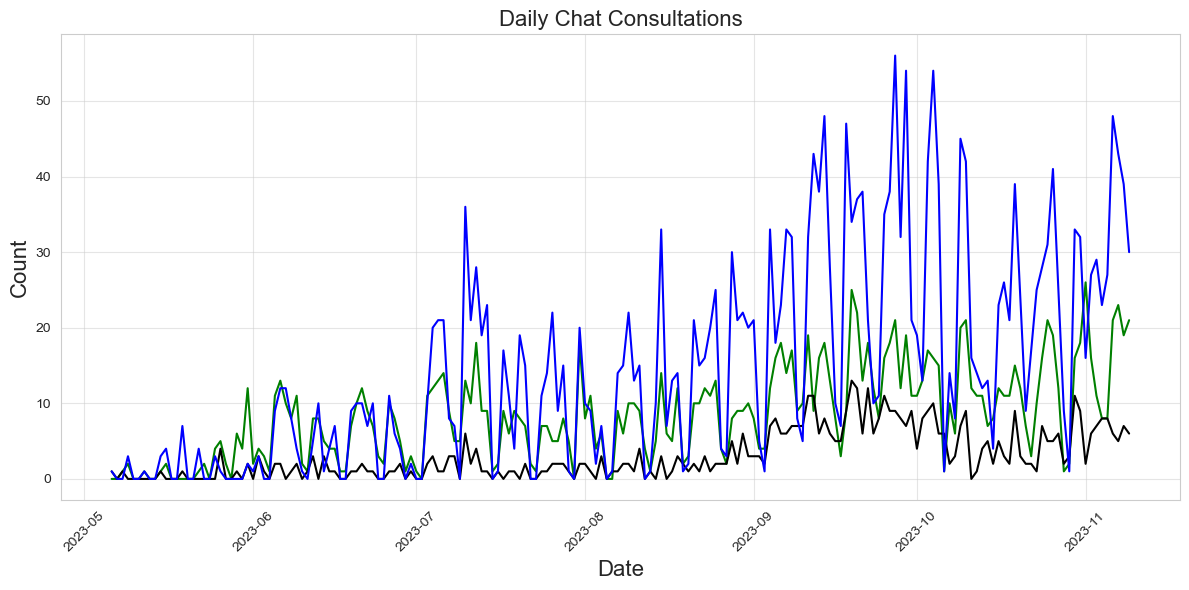

In [968]:
# Set a Seaborn style and color palette
sns.set_style("whitegrid")
sns.set_palette("tab10")

# Create a line plot
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.lineplot(data=df_ml_vis, x=df_ml_vis.index, y='working_hours_lawyers', color='green')
sns.lineplot(data=df_ml_vis, x=df_ml_vis.index, y='late_hours_lawyers', color='black')
sns.lineplot(data=df_daily_count, x='date', y='count', color='blue')


# Customize the plot
plt.title('Daily Chat Consultations', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Add grid lines
plt.grid(True, alpha=0.5)

# Show the plot
plt.tight_layout()  # Ensure all elements fit nicely
plt.show()

In [969]:
import joblib
#save model
joblib.dump(model_lr, 'linear_regression_model_with_bug.pkl')

['linear_regression_model_with_bug.pkl']

In [923]:
#save model
joblib.dump(model_lr, 'linear_regression_model.pkl')

['linear_regression_model.pkl']

In [312]:
loaded_model = joblib.load('linear_regression_model.pkl')
forecast_lr = loaded_model.predict(X_test)### Linear regression 

### Forecast Future using LGB

In [791]:
model_lgb = lgb.LGBMRegressor(verbose=-1)
model_lgb.fit(X_train, y_train)
forecast_lgb = model_lgb.predict(X_test)### Linear regression 

In [817]:
# Create and fit a Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Make predictions on the test set
forecast_lr = model_lr.predict(X_test)### Linear regression 

In [830]:
alpha = 0.2
residuals = y_test - forecast_lr
mse = np.mean(residuals ** 2)
prediction_std = np.sqrt(mse)

n = len(X_test)
t_score = np.abs(np.percentile(np.random.standard_t(df=n-2, size=10000), 100 * (1 - alpha / 2)))

# Calculate the prediction interval for each data point
prediction_interval_lower = forecast_lr - t_score * prediction_std
prediction_interval_upper = forecast_lr + t_score * prediction_std

In [831]:
df_ex =  y_test.to_frame()
df_ex['forecast'] = forecast_lr
df_ex['upper'] = prediction_interval_upper
df_ex['lower'] = prediction_interval_lower

In [924]:
t_score

1.2995244830227315

In [925]:
prediction_std

8.326720491219286

In [832]:
df_ex.head()

,count,forecast,upper,lower
date,,,,
2023-10-11,16,31.420548,42.241325,20.599771
2023-10-12,14,18.706012,29.526789,7.885234
2023-10-13,12,21.928374,32.749151,11.107597
2023-10-14,13,13.048198,23.868975,2.227421
2023-10-15,4,16.149602,26.970379,5.328825


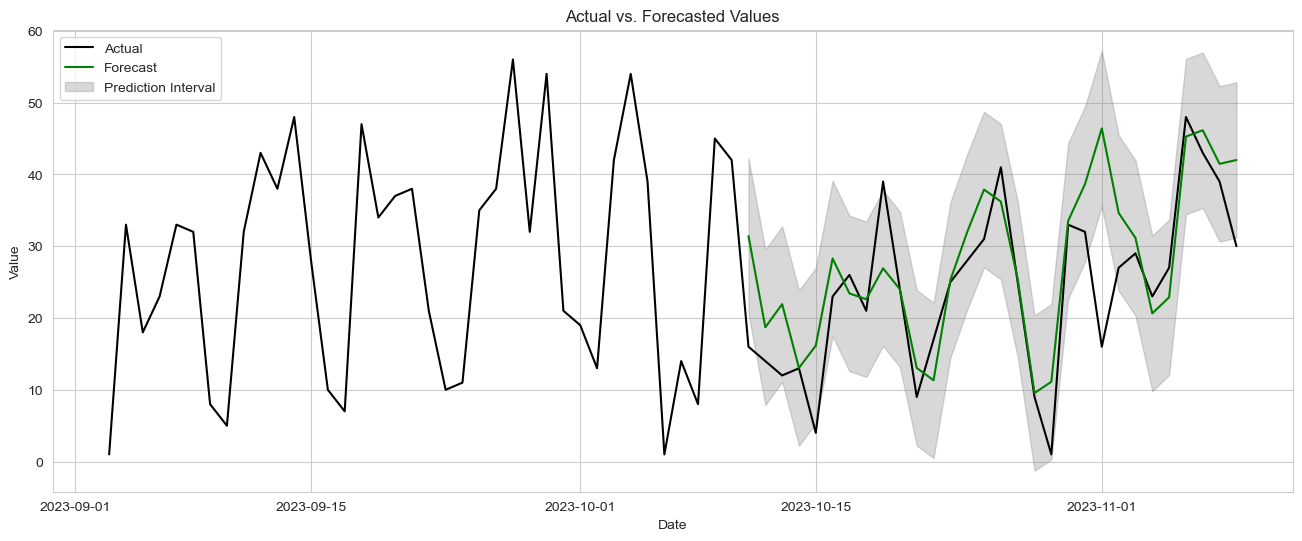

In [833]:
# Plot actual, training, and forecasted values for the test set
plt.figure(figsize=(16, 6))
plt.plot(df_daily_count['date'][120:], df_daily_count['count'][120:], label='Actual', color='black')
plt.plot(df_ex.index, df_ex['forecast'], label='Forecast', color='green')
# Add prediction intervals
plt.fill_between(df_ex.index, df_ex['lower'], df_ex['upper'], color='gray', alpha=0.3, label='Prediction Interval')


plt.title('Actual vs. Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [834]:
df_ml_vis.columns

Index(['count', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7',
       'web_visitor', 'working_hours_lawyers', 'late_hours_lawyers',
       'cpa_google', 'cpa_meta', 'inq'],
      dtype='object')

In [890]:
forecast_horizon = 52
start_date = pd.to_datetime(df_ml_vis.index[-1]) + pd.DateOffset(days=1)
date_range = pd.date_range(start_date, periods=forecast_horizon, freq='D')
forecast_df = pd.DataFrame(index=date_range, columns=["forecasted_value"])
forecast_template = pd.DataFrame(index=date_range, columns=["forecasted_value"])


In [891]:
web_vis = pd.read_csv('webvisitor_forecast_1109.csv')
web_vis = web_vis.rename(columns={'Unnamed: 0':'date', 'forecasted_value':'web_vis_proj'})
web_vis.set_index('date', inplace=True)
web_vis.head()

,web_vis_proj
date,
2023-11-10,679.274902
2023-11-11,692.016418
2023-11-12,691.122620
2023-11-13,310.982513
2023-11-14,227.252045


In [898]:
forecast_template = web_vis.copy()

In [980]:
#web visitor = 533
# forecast_template['web_visitor'] = web_vis['forecasted_value']
#working hours lawyers
forecast_template['working_hours_lawyers'] = 15
#late hours lawyers
forecast_template['late_hours_lawyers'] = 15
#cpa google
forecast_template['cpa_google'] = 1000
#cpa meta
forecast_template['cpa_meta'] = 1000
# cum_major_bug
forecast_template['cum_major_bug'] = 30
# cum_minor_bug
forecast_template['cum_minor_bug'] = 13
# inq
forecast_template['inq'] = 190

In [981]:
# Assuming forecast_template is a DataFrame with columns ['web_visitor', 'working_hours_lawyers', 'late_hours_lawyers', 'cpa_google', 'cpa_meta', 'cum_major_bug', 'cum_minor_bug', 'inq']
columns_to_append = ['web_visitor', 'working_hours_lawyers', 'late_hours_lawyers', 'cpa_google', 'cpa_meta', 'cum_major_bug', 'cum_minor_bug', 'inq']

# Initialize latest_data_row with the initial row
latest_data_row = np.array([])

for i in range(forecast_horizon):
    latest_data_row = np.append(latest_data_row, forecast_template[columns_to_append].iloc[i])


KeyError: "['web_visitor'] not in index"

In [976]:
forecast_template

,web_vis_proj,working_hours_lawyers,late_hours_lawyers,cpa_google,cpa_meta,inq
date,,,,,,
2023-11-10,679.274902,15,15,1000,1000,190
2023-11-11,692.016418,15,15,1000,1000,190
2023-11-12,691.122620,15,15,1000,1000,190
2023-11-13,310.982513,15,15,1000,1000,190
2023-11-14,227.252045,15,15,1000,1000,190
2023-11-15,1002.673706,15,15,1000,1000,190
2023-11-16,1157.912476,15,15,1000,1000,190
2023-11-17,1077.873047,15,15,1000,1000,190
2023-11-18,869.133057,15,15,1000,1000,190


In [983]:
columns_to_append = ['web_vis_proj', 'working_hours_lawyers', 'late_hours_lawyers', 'cpa_google', 'cpa_meta', 'cum_major_bug', 'cum_minor_bug', 'inq']
forecast_template[columns_to_append]

,web_vis_proj,working_hours_lawyers,late_hours_lawyers,cpa_google,cpa_meta,cum_major_bug,cum_minor_bug,inq
date,,,,,,,,
2023-11-10,679.274902,15,15,1000,1000,30,13,190
2023-11-11,692.016418,15,15,1000,1000,30,13,190
2023-11-12,691.122620,15,15,1000,1000,30,13,190
2023-11-13,310.982513,15,15,1000,1000,30,13,190
2023-11-14,227.252045,15,15,1000,1000,30,13,190
2023-11-15,1002.673706,15,15,1000,1000,30,13,190
2023-11-16,1157.912476,15,15,1000,1000,30,13,190
2023-11-17,1077.873047,15,15,1000,1000,30,13,190
2023-11-18,869.133057,15,15,1000,1000,30,13,190


In [984]:
forecast_array = []  # Renamed from 'forecast_value'
latest_data_row = df_ml_vis.iloc[-1, 0:7].to_numpy().reshape(1, -1)

columns_to_append = ['web_vis_proj', 'working_hours_lawyers', 'late_hours_lawyers', 'cpa_google', 'cpa_meta', 'cum_major_bug', 'cum_minor_bug', 'inq']

for i in range(forecast_horizon):
#     latest_data_row_1 = np.append(latest_data_row, forecast_template['web_vis_proj'].iloc[i])
#     latest_data_row_2 = np.append(latest_data_row_1, forecast_template['working_hours_lawyers'].iloc[i])
#     latest_data_row_3 = np.append(latest_data_row_2, forecast_template['late_hours_lawyers'].iloc[i])
#     latest_data_row_4 = np.append(latest_data_row_3, forecast_template['cpa_google'].iloc[i])
#     latest_data_row_5 = np.append(latest_data_row_4, forecast_template['cpa_meta'].iloc[i])
#     latest_data_row_6 = np.append(latest_data_row_5, forecast_template['cum_major_bug'].iloc[i])
#     latest_data_row_7 = np.append(latest_data_row_6, forecast_template['cum_minor_bug'].iloc[i])
#     latest_data_row_6 = np.append(latest_data_row_5, forecast_template['inq'].iloc[i])
    latest_data_row = np.append(latest_data_row, forecast_template[columns_to_append].iloc[i])
    
    latest_data_row = latest_data_row.reshape(1, -1)
    predicted_result = model_lr.predict(latest_data_row)
    
    new_data_row = np.concatenate((predicted_result, latest_data_row[0]))
    print(new_data_row)
    
    forecast_array.append(new_data_row)
    
    latest_data_row = new_data_row[0:7].reshape(1, -1)
    
forecast_value = [array[0] for array in forecast_array]
forecast_df["forecasted_value"] = forecast_value

[  39.60791073   30.           39.           43.           48.
   27.           23.           29.          679.27490234   15.
   15.         1000.         1000.           30.           13.
  190.        ]
[  39.59869214   39.60791073   30.           39.           43.
   48.           27.           23.          692.01641846   15.
   15.         1000.         1000.           30.           13.
  190.        ]
[  43.60685066   39.59869214   39.60791073   30.           39.
   43.           48.           27.          691.12261963   15.
   15.         1000.         1000.           30.           13.
  190.        ]
[  39.15384967   43.60685066   39.59869214   39.60791073   30.
   39.           43.           48.          310.98251343   15.
   15.         1000.         1000.           30.           13.
  190.        ]
[  38.3794667    39.15384967   43.60685066   39.59869214   39.60791073
   30.           39.           43.          227.25204468   15.
   15.         1000.         1000.           3

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid fea

In [914]:
forecast_df['upper'] = forecast_value + t_score * prediction_std
forecast_df['lower'] = forecast_value - t_score * prediction_std


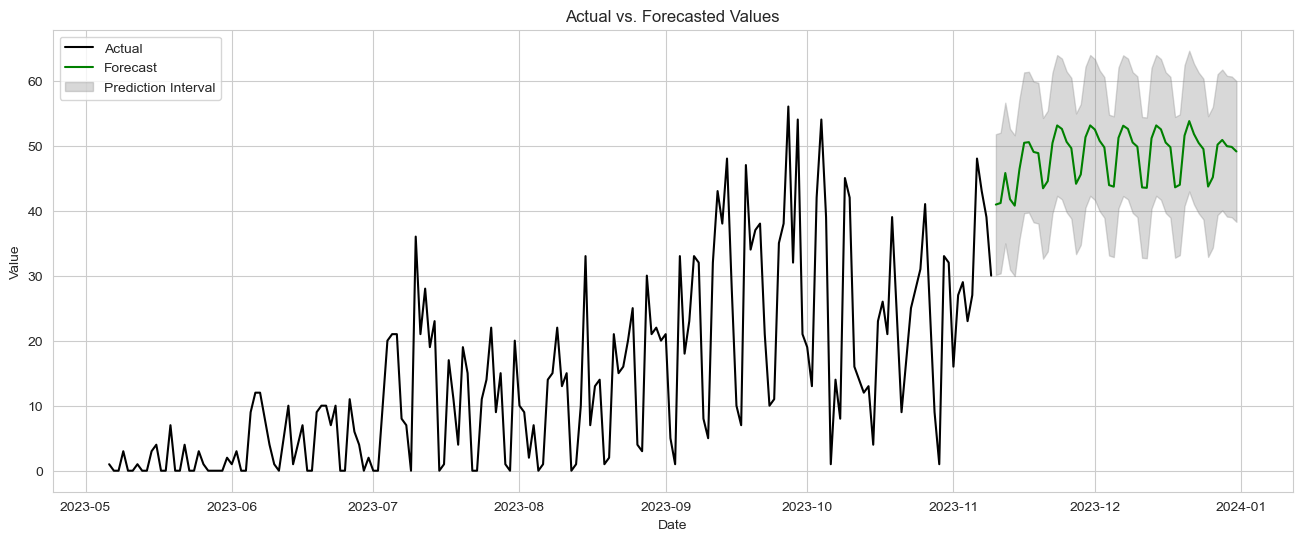

In [915]:
# Plot actual, training, and forecasted values for the test set
plt.figure(figsize=(16, 6))
plt.plot(df_daily_count['date'], df_daily_count['count'], label='Actual', color='black')
plt.plot(forecast_df.index, forecast_df['forecasted_value'], label='Forecast', color='green')
# Add prediction intervals
plt.fill_between(forecast_df.index, forecast_df['lower'], forecast_df['upper'], color='gray', alpha=0.3, label='Prediction Interval')


plt.title('Actual vs. Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [772]:
forecast_df.sum()

forecasted_value    1666.239458
upper               2195.741619
lower               1136.737297
dtype: float64

In [766]:
forecast_df.sum()

forecasted_value    1516.002148
upper               2045.504309
lower                986.499987
dtype: float64

In [719]:
forecast_df.sum()

forecasted_value    1088.599228
upper               1618.101389
lower                559.097067
dtype: float64

## Forecast Future using linear regression

In [987]:
# Create and fit a Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Make predictions on the test set
forecast_lr = model_lr.predict(X_test)### Linear regression 

In [988]:
forecast_lr = model_lr.predict(X_test)### Linear regression 

In [989]:
alpha = 0.2
residuals = y_test - forecast_lr
mse = np.mean(residuals ** 2)
prediction_std = np.sqrt(mse)

n = len(X_test)
t_score = np.abs(np.percentile(np.random.standard_t(df=n-2, size=10000), 100 * (1 - alpha / 2)))

# Calculate the prediction interval for each data point
prediction_interval_lower = forecast_lr - t_score * prediction_std
prediction_interval_upper = forecast_lr + t_score * prediction_std

In [990]:
# Define the number of days to forecast
prediction_interval_lower

array([18.5958833 ,  9.30766815, 14.30421763,  4.84211162,  7.87804277,
       19.45425989, 14.47373967, 14.19317116, 19.60333   , 15.75297766,
        4.34161441,  3.2963306 , 15.45671816, 23.04366024, 28.96828415,
       26.67708728, 16.22318759,  0.38629164,  1.85478099, 23.82962183,
       22.53446988, 27.48021211, 34.73720986, 23.53218057, 21.27607674,
       11.58542043, 13.59157177, 33.19606192, 33.97844915, 29.64902242,
       29.40467626])

## read website visitor forecast


In [87]:
df_visitor_forecast = pd.read_csv('webvisitor_forecast_2.csv')
df_visitor_forecast = df_visitor_forecast[['forecasted_value']]
df_visitor_forecast.head()

,forecasted_value
0,830.099941
1,896.151024
2,885.707071
3,354.030998
4,199.381442


In [88]:
merged_onboard = pd.merge(df_daily, df_onboard, on='week', how='left')

In [89]:
# Create a date range from 2023-10-20 to 2023-12-31
start_date = datetime(2023, 10, 20)
end_date = datetime(2023, 12, 31)
date_range = pd.date_range(start_date, end_date)

# Create a DataFrame with 'date' and 'value' columns
data = {'date': date_range, 'value': [np.nan] * len(date_range)}
df_onboard_proj = pd.DataFrame(data)

In [90]:
df_onboard_proj['value'] = 7
df_onboard_proj

,date,value
0,2023-10-20,7
1,2023-10-21,7
2,2023-10-22,7
3,2023-10-23,7
4,2023-10-24,7
...,...,...
68,2023-12-27,7
69,2023-12-28,7
70,2023-12-29,7
71,2023-12-30,7


/var/folders/fh/5kqpbzgx5cgdq_m9npj98tfh0000gn/T/ipykernel_3758/4107813228.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lawyer_count.rename(columns={'date':'ds', 'lawyer_online_count':'y'}, inplace=True)
11:06:08 - cmdstanpy - INFO - Chain [1] start processing
11:06:08 - cmdstanpy - INFO - Chain [1] done processing


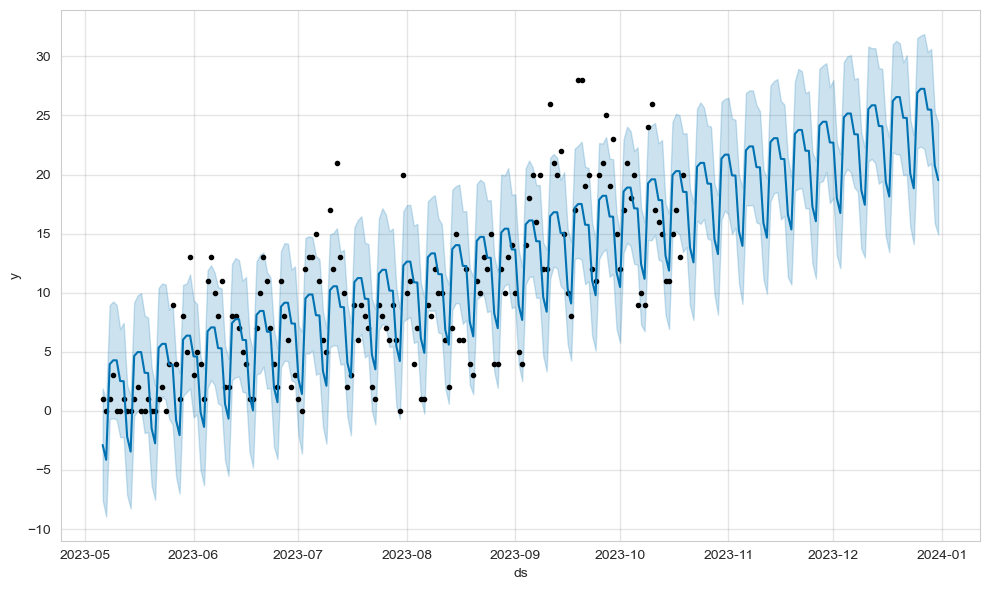

In [91]:
lawyer_count = df_ml_vis[['lawyer_online_count']]
#projected pb prophet
lawyer_count.reset_index(inplace=True)
lawyer_count.rename(columns={'date':'ds', 'lawyer_online_count':'y'}, inplace=True)

model = Prophet()
model.fit(lawyer_count)
future = model.make_future_dataframe(periods=73)  # Forecast for the next year

# Generate forecasts
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.show()


In [92]:
df_forecast_lawyer = forecast[forecast['ds'] > '2023-10-19']
df_forecast_lawyer = df_forecast_lawyer[['yhat']]

In [93]:
# df_forecast_lawyer['yhat'] = 20

In [94]:
# forecast_array = []  # Renamed from 'forecast_value'
# latest_data_row = df_ml_vis.iloc[-1, 0:7].to_numpy().reshape(1, -1)
# latest_data_row

In [117]:
forecast_horizon = 73
forecast_array = []  # Renamed from 'forecast_value'
latest_data_row = df_ml_vis.iloc[-1, 0:7].to_numpy().reshape(1, -1)

for i in range(forecast_horizon):
    
    latest_data_row_1 = np.append(latest_data_row, df_visitor_forecast.iloc[i])
    latest_data_row_2 = np.append(latest_data_row_1, df_onboard_proj.iloc[i][1])
    latest_data_row_3 = np.append(latest_data_row_2, df_forecast_lawyer.iloc[i])
    latest_data_row_4 = latest_data_row_3.reshape(1, -1)
    predicted_result = model_lr.predict(latest_data_row_4)
    
    new_data_row = np.concatenate((predicted_result, latest_data_row_4[0]))
    print(new_data_row)
    forecast_array.append(new_data_row)
    
    latest_data_row = new_data_row[:-4].reshape(1, -1)
    
forecast_value = [array[0] for array in forecast_array]


[ 28.6829191   39.          21.          26.          23.
   4.          13.          12.         830.09994078   7.
  18.51916086]
[ 21.69663288  28.6829191   39.          21.          26.
  23.           4.          13.         896.15102375   7.
  13.81931132]
[ 21.93851846  21.69663288  28.6829191   39.          21.
  26.          23.           4.         885.70707075   7.
  12.56842379]
[ 28.8537267   21.93851846  21.69663288  28.6829191   39.
  21.          26.          23.         354.0309985    7.
  20.65307109]
[ 25.06993674  28.8537267   21.93851846  21.69663288  28.6829191
  39.          21.          26.         199.38144198   7.
  20.98587703]
[ 33.92337316  25.06993674  28.8537267   21.93851846  21.69663288
  28.6829191   39.          21.         781.18827404   7.
  20.98527502]
[ 36.24707859  33.92337316  25.06993674  28.8537267   21.93851846
  21.69663288  28.6829191   39.         964.07044502   7.
  19.23426393]
[ 33.36832845  36.24707859  33.92337316  25.06993674  28.853

/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/fadilrisdian/miniconda3/envs/perqara-zth/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid fea

In [118]:
forecast_data = df_ml_vis.copy()
start_date = forecast_data.index.max() + pd.Timedelta(days=1)
date_range = pd.date_range(start_date, periods=forecast_horizon, freq='D')
forecast_df = pd.DataFrame(index=date_range, columns=["forecasted_value"])

In [119]:
len(forecast_value)

73

In [120]:
forecast_df

,forecasted_value
2023-10-20,NaN
2023-10-21,NaN
2023-10-22,NaN
2023-10-23,NaN
2023-10-24,NaN
...,...
2023-12-27,NaN
2023-12-28,NaN
2023-12-29,NaN
2023-12-30,NaN


In [121]:
forecast_df["forecasted_value"] = forecast_value

In [122]:
forecast_df.index

DatetimeIndex(['2023-10-20', '2023-10-21', '2023-10-22', '2023-10-23',
               '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27',
               '2023-10-28', '2023-10-29', '2023-10-30', '2023-10-31',
               '2023-11-01', '2023-11-02', '2023-11-03', '2023-11-04',
               '2023-11-05', '2023-11-06', '2023-11-07', '2023-11-08',
               '2023-11-09', '2023-11-10', '2023-11-11', '2023-11-12',
               '2023-11-13', '2023-11-14', '2023-11-15', '2023-11-16',
               '2023-11-17', '2023-11-18', '2023-11-19', '2023-11-20',
               '2023-11-21', '2023-11-22', '2023-11-23', '2023-11-24',
               '2023-11-25', '2023-11-26', '2023-11-27', '2023-11-28',
               '2023-11-29', '2023-11-30', '2023-12-01', '2023-12-02',
               '2023-12-03', '2023-12-04', '2023-12-05', '2023-12-06',
               '2023-12-07', '2023-12-08', '2023-12-09', '2023-12-10',
               '2023-12-11', '2023-12-12', '2023-12-13', '2023-12-14',
      

In [123]:
forecast_df['date'] = pd.to_datetime(forecast_df.index)  # Ensure it's a datetime object
df_november = forecast_df[forecast_df['date'].dt.month == 11] 
df_desember = forecast_df[forecast_df['date'].dt.month == 12] 

In [104]:
df_november['forecasted_value'].sum()/30

40.717630175791236

In [126]:
df_desember['forecasted_value'].sum()/30

49.99786030475173

In [98]:
sum(forecast_value)

3063.625575463185

In [300]:
# Calculate the prediction interval for each data point
prediction_interval_lower = y_pred_lr - t_score * prediction_std
prediction_interval_upper = y_pred_lr + t_score * prediction_std

forecast_df['lower'] = forecast_df["forecasted_value"] - t_score * prediction_std
forecast_df['upper'] = forecast_df["forecasted_value"] + t_score * prediction_std


In [54]:
y_pred_lr

array([11.60797733, 17.12101787, 33.68112607, 33.20147469, 39.33828793,
       30.62669414, 32.06817147, 19.24069608, 19.63782349, 26.92113474,
       39.15210305, 32.10137758, 36.96460295, 23.14319885, 16.37230559,
       13.0723073 , 33.40623999, 41.23237728, 34.53853968, 24.123516  ,
       23.09915709, 13.46610908, 15.74049039, 28.42852897, 26.02759316,
       18.94988632, 24.915347  ])

In [53]:
prediction_std

10.7334146469441

In [301]:
df_daily_count['count'].sum()

2189

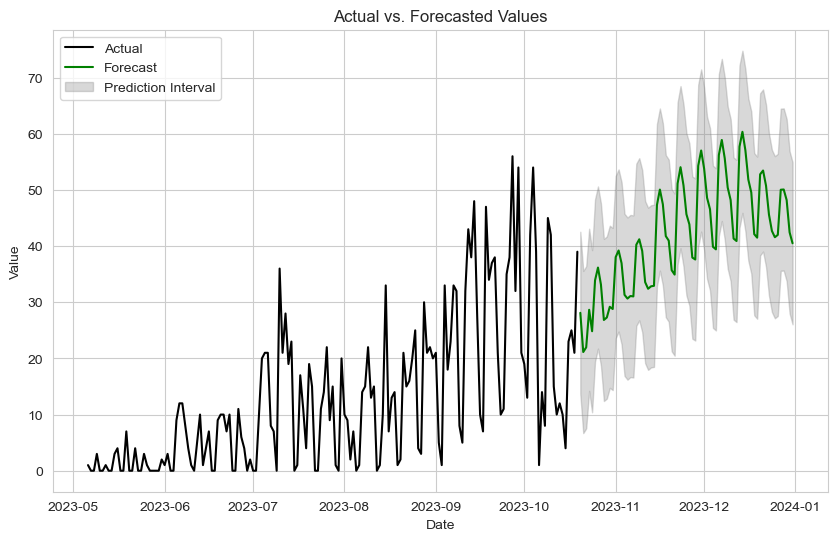

In [302]:
# Plot actual, training, and forecasted values for the test set
plt.figure(figsize=(10, 6))
plt.plot(df_daily_count['date'], df_daily_count['count'], label='Actual', color='black')
plt.plot(forecast_df.index, forecast_df['forecasted_value'], label='Forecast', color='green')
# Add prediction intervals
plt.fill_between(forecast_df.index, forecast_df['lower'], forecast_df['upper'], color='gray', alpha=0.3, label='Prediction Interval')


plt.title('Actual vs. Forecasted Values')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()